# Implementing the Optimal Transport Algorithm for Graphs

In [23]:
import numpy as np
from scipy.optimize import linprog
from scipy.stats import norm
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, csc_matrix, hstack

### Setup 

Choose a set of points on $[0,1]^d$ to generate a nearest-neighbor graph. Produce neighbors with a previously developed algorithm and initialize *source* and *sink* vectors as pmfs supported on the nodes of the graph. (These can be normalized, but I'm not sure if that helps.)

In [374]:
def get_k_neighbors(X, k):
    # Inputs:
    # X - a cluster of points in the form of a 2D numpy array
    # k - number of neighbors desired
    #
    # Outputs:
    # indices - list of indices of nearest neighbors, with a list for each input point

    nbrs = NearestNeighbors(n_neighbors = k + 1, algorithm = "kd_tree").fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    return np.delete(indices, 0, axis = 1)

In [481]:
def get_k_partitioned_neighbors(X, k, num_partitions):
    # Inputs:
    # X - a cluster of points in the form of a 2D numpy array
    # k - number of neighbors desired
    # num_partitions - number of partitions into which X will be divided
    #
    # Outputs:
    # neighbors - list of indices of nearest neighbors, with a list for each input point
    
    # np.random.shuffle(X)     # remove structure within X to randomize partitions
    partitions = np.array_split(X, num_partitions)  # list of partitions
    
    # assign sink-partition not equal to source partition for each point in X.
    sinks = np.zeros(0)
    for source in range(num_partitions):
        possible_sinks = [i for i in range(num_partitions) if i != source]
        sinks = np.append(sinks, np.random.choice(a = possible_sinks, size = len(partitions[source])))
    
    neighbors = np.zeros((len(X), k))
    offset = 0
    for sink in range(num_partitions):
        # within the current sink partition, get all indices and points
        indices = (sinks == sink).nonzero()[0]
        points = X[indices]
        
        # fit kNN on current partition
        nbrs = NearestNeighbors(n_neighbors = k, algorithm = "kd_tree").fit(partitions[sink])
        # find neighbors (within partition) of the points to be compared
        partition_ind = nbrs.kneighbors(points)[1]
        
        #store indices of neighbors
        for i in range(len(indices)):
            neighbors[indices[i]] = partition_ind[i] + offset
        offset += len(partitions[sink])
        
    return neighbors

In [365]:
# Generate graph and find neighbors
n_points = 200
X = np.random.uniform(0, 1, size = (n_points,2))
X_nbrs_partition = get_k_partitioned_neighbors(X, 2, 3)

In [366]:
# Place normal pdf on first 20 points of source and the same values as the last 20 points of sink

x = np.linspace(-3,3,20)
pmf = norm.pdf(x)
zeros = np.zeros(n_points - 20)

source = np.concatenate((pmf, zeros))
sink = np.concatenate((zeros, pmf))

### Creating matrices

Using the list of neighbors of G, make the incidence matrices *Q* and *Q~*. Concatenate these to form the matrix *\~Q\~*.

In [367]:
def make_QQ(neighbors):
    n, k = neighbors.shape
    ind = np.tile(np.arange(n), k).reshape(-1,1)
    collapsed_nbrs = neighbors.reshape(-1,1, order = 'F')
    
    edges = np.concatenate((ind, collapsed_nbrs), axis = 1)
    # sort edges (!?) to eliminate identical edges
    unique_edges = np.unique(np.sort(edges, axis = 1), axis = 0)

    n_edges = len(unique_edges)
    vals = np.array([1, -1]*n_edges)
    row_ind = unique_edges.flatten()
    col_ptr = np.arange(n_edges + 1) * 2
    
    return hstack((csc_matrix((vals, row_ind, col_ptr)), csc_matrix((-vals, row_ind, col_ptr))))

In [368]:
combined_Q = make_QQ(X_nbrs_partition)

### Minimizing weights

Solve a linear programming problem that multiplies *combined_Q* by the weight vector *w* while minimizing the sum of *w*'s components.

In [503]:
def get_weights(QQ, source, sink):
    output = linprog(c = np.ones(QQ.shape[1]), A_eq = QQ, b_eq = sink-source)
    return np.round(output.x, 8)

## Visualize optimized transport path

In [380]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [495]:
def draw_digraph(X, source_pmf, sink_pmf, QQ):
    # Inputs:
    # X - a cluster of points in the form of a 2D numpy array
    # QQ - a sparse matrix of -1, 0, 1 that encodes vertex adjacencies
    # weights - an array of weights to be assigned to each edge in QQ
    #
    # Output:
    # G - the resulting graph
    #
    # Displays a graph with nodes at the points of X, connected with weighted edges
    
    G = nx.DiGraph()
    # insert nodes
    G.add_nodes_from(range(len(X)))
    
    # get edge weights
    weights = get_weights(QQ, source_pmf, sink_pmf)
    
    #insert edges
    num_edges = QQ.shape[1]//2
    for i in range(num_edges):
        edge = QQ[:,i].indices
        weight = weights[num_edges + i] - weights[i]
        
        if weight < 0:
            G.add_edge(edge[1], edge[0], weight = -weight)
        else:
            G.add_edge(edge[0], edge[1], weight = weight)
            
    #return G
    
    # store coordinate values as node positions
    pos = dict(enumerate(X))
    
    # set colors and sizes for nodes
    is_source = source_pmf - sink_pmf
    source_color = '#FFBC38'   #orange
    sink_color = '#5D92F3'     #blue
    zero_color = '#B1B1B1'     #gray
    node_colors = np.where(is_source > 0, source_color, np.where(is_source == 0, zero_color, sink_color))
    node_sizes = 200*(np.abs(source_pmf) + np.abs(sink_pmf)) + 30
    
    # set colors (opacity) for edges
    edge_colors = [(.5,.5,.5,np.sqrt(G[u][v]['weight'])) for u,v in G.edges()]
    
    # draw graph
    nx.drawing.nx_pylab.draw_networkx(G, pos, with_labels = False, arrows = True, 
                                      arrowsize = 10, arrowstyle = '-|>', edge_color = edge_colors, 
                                      node_color = node_colors, 
                                      width = 3, 
                                      node_size = node_sizes)

    return G

Old graph-plotting functions copied from before:

In [355]:
def create_graph(X, neighbors):
    # Inputs:
    # X - a cluster of points in the form of a 2D numpy array
    # k - a list of neighbors to be connected to each point in X, given by their indices
    #
    # Output:
    # G - the resulting graph
    #
    # Displays a graph with nodes at the points of X and connected neighbors
    
    pos = dict(enumerate(X))
    
    G = nx.Graph()
    G.add_nodes_from(range(len(X)))
    
    # for each node, add an edge for each neighbor 
    for n in pos.keys():
        G.add_edges_from([(n, i) for i in neighbors[n]])
    
    return G, pos

In [450]:
def draw_graph(G):
    plt.cla()
    nx.drawing.nx_pylab.draw_networkx(G[0], pos = G[1], 
                                      with_labels = False, node_size = 20, 
                                      linewidths = 0.5)

### First Example

Key features:

* 200 randomly, uniformly generated points
* 20 random source points
* 20 random sink points
* both source and sink points are fitted with a normal pmf

Number of partition-neighbors: 2 of 6 <br>
Number of nearest neighbors: 4

c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  
c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\_linprog_util.py:747: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)
c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  
c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\_linprog_util.py:747: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)


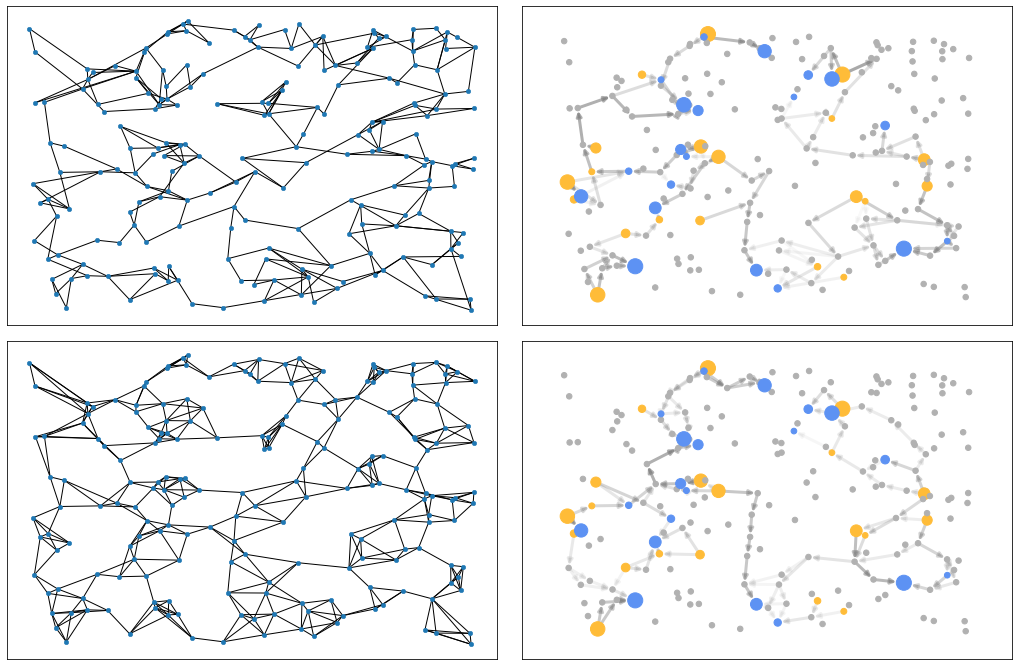

In [444]:
fig = plt.figure(figsize = (18,12))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# draw connected graph and transport plan under k-partitioned connectedness
plt.subplot(2, 2, 1)
draw_graph(create_graph(X, X_nbrs_partition))

plt.subplot(2, 2, 2)
G1_partition = draw_digraph(X, source, sink, make_QQ(X_nbrs_partition))

# draw connected graph and transport plan under k-nearest connectedness
X_nbrs_nearest = get_k_neighbors(X, 4)

plt.subplot(2, 2, 3)
draw_graph(create_graph(X, X_nbrs_nearest))

plt.subplot(2, 2, 4)
G1_nearest = draw_digraph(X, source, sink, make_QQ(X_nbrs_nearest))

### Second Example

Key features:
* Large, distinct source and sink clusters with filler nodes in between.
* 300 points
* 100 source points in lower quadrant
* 100 sink points in upper quadrant
* 100 uniformly generated points in the entire space

Number of partition-neighbors: 2 of 6 <br>
Number of nearest neighbors: 5

c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  
c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\_linprog_util.py:747: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)
c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  
c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\_linprog_util.py:747: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)


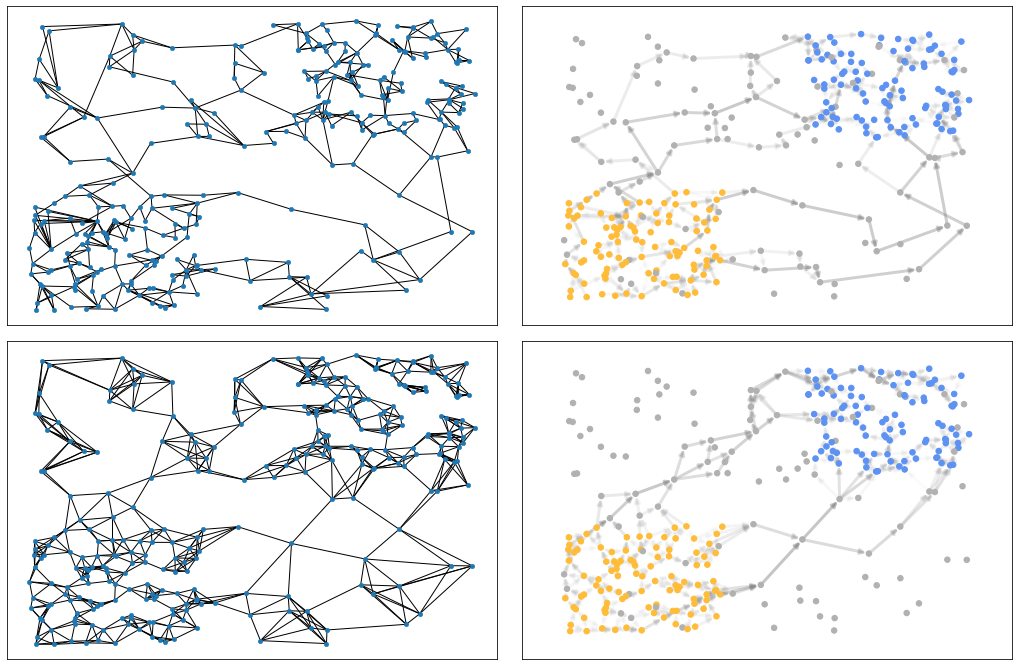

In [498]:
# Initialize graph properties
n2 = 300
third = n2//3
source2 = np.random.uniform(0, .4, size = (third,2))
sink2 = np.random.uniform(.6, 1, size = (third,2))
X2 = np.concatenate((source2, sink2, np.random.uniform(0, 1, size = (third,2))))

source2_pmf = np.concatenate((1/2/third*np.ones(third), np.zeros(third), np.zeros(third)))
sink2_pmf = np.concatenate((np.zeros(third), 1/2/third*np.ones(third), np.zeros(third)))

# shuffle data to allow for random partitions
data2 = np.concatenate((X2, source2_pmf.reshape(-1,1), sink2_pmf.reshape(-1,1)), axis = 1)
np.random.shuffle(data2)

X2 = data2[:,0:2]
source2_pmf = data2[:,2]
sink2_pmf = data2[:,3]

# assign neighbors
X2_nbrs_partition = get_k_partitioned_neighbors(X2, 2, 3)
X2_nbrs_nearest = get_k_neighbors(X2, 5)

# start plotting
fig = plt.figure(figsize = (18,12))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# draw connected graph and transport plan under k-partitioned connectedness
plt.subplot(2, 2, 1)
draw_graph(create_graph(X2, X2_nbrs_partition))

plt.subplot(2, 2, 2)
G2_partition = draw_digraph(X2, source2_pmf, sink2_pmf, make_QQ(X2_nbrs_partition))

# draw connected graph and transport plan under k-nearest connectedness
plt.subplot(2, 2, 3)
draw_graph(create_graph(X2, X2_nbrs_nearest))

plt.subplot(2, 2, 4)

G2_nearest = draw_digraph(X2, source2_pmf, sink2_pmf, make_QQ(X2_nbrs_nearest))

### Third Example

Key features:
* Two rings of points as source and sink
* 100 points in inner ring (source)
* 200 points in outer ring (sink)
* 50 uniformly distributed bridging points

Number of partition-neighbors: 2 of 8 <br>
Number of nearest neighbors: 5

c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  
c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\_linprog_util.py:747: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)
c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.
  
c:\users\austin\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\_linprog_util.py:747: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning, stacklevel=1)


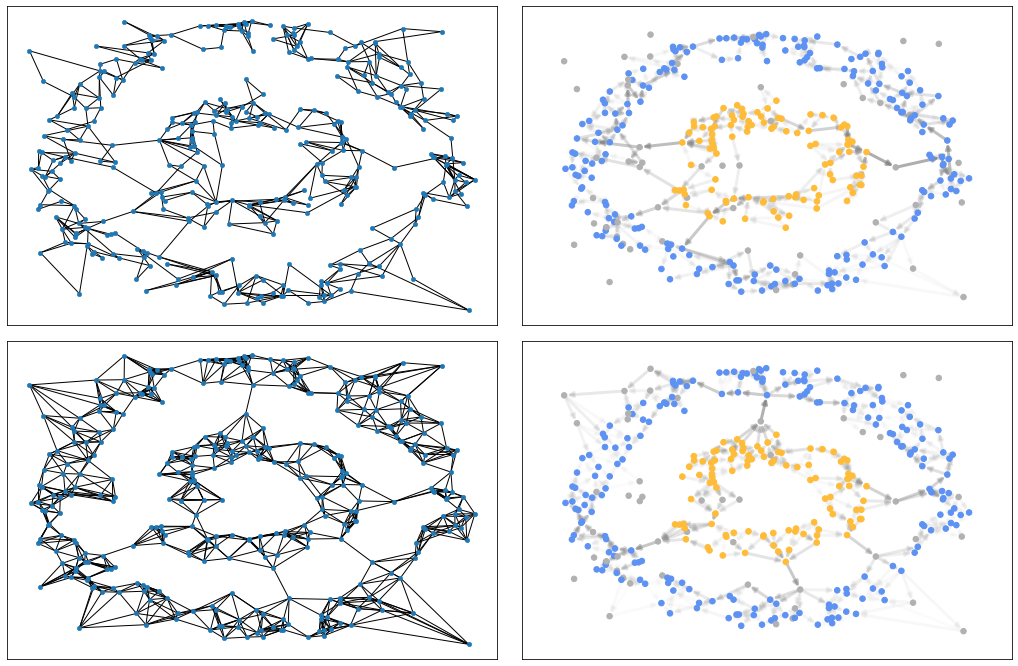

In [507]:
# Initialize graph properties
n3 = 300
n_inner = n3//3
n_outer = 2*n3//3
n_bridge = 50

r_inner = np.random.uniform(.25, .5, size = (n_inner)).reshape(-1,1)
theta_inner = np.random.uniform(0, 6.283, size = (n_inner)).reshape(-1,1)
X_inner = np.concatenate((r_inner * np.cos(theta_inner), r_inner * np.sin(theta_inner)),1)

r_outer = np.random.uniform(.75, 1, size = (n_outer)).reshape(-1,1)
theta_outer = np.random.uniform(0, 6.283, size = (n_outer)).reshape(-1,1)
X_outer = np.concatenate((r_outer * np.cos(theta_outer), r_outer * np.sin(theta_outer)),1)

X3 = np.concatenate((X_inner, X_outer, np.random.uniform(-1,1,size = (n_bridge, 2))))

source3_pmf = np.concatenate((1/n_inner*np.ones(n_inner), np.zeros(n_outer), np.zeros(n_bridge)))
sink3_pmf = np.concatenate((np.zeros(n_inner), 1/n_outer*np.ones(n_outer), np.zeros(n_bridge)))

# shuffle data to allow for random partitions
data3 = np.concatenate((X3, source3_pmf.reshape(-1,1), sink3_pmf.reshape(-1,1)), axis = 1)
np.random.shuffle(data3)

X3 = data3[:,0:2]
source3_pmf = data3[:,2]
sink3_pmf = data3[:,3]

# assign neighbors
X3_nbrs_partition = get_k_partitioned_neighbors(X3, 2, 4)
X3_nbrs_nearest = get_k_neighbors(X3, 6)

# start plotting
fig = plt.figure(figsize = (18,12))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# draw connected graph and transport plan under k-partitioned connectedness
plt.subplot(2, 2, 1)
draw_graph(create_graph(X3, X3_nbrs_partition))

plt.subplot(2, 2, 2)
G3_partition = draw_digraph(X3, source3_pmf, sink3_pmf, make_QQ(X3_nbrs_partition))

# draw connected graph and transport plan under k-nearest connectedness
plt.subplot(2, 2, 3)
draw_graph(create_graph(X3, X3_nbrs_nearest))

plt.subplot(2, 2, 4)
G3_nearest = draw_digraph(X3, source3_pmf, sink3_pmf, make_QQ(X3_nbrs_nearest))

In [512]:
for line in nx.generate_edgelist(G):
    print(line)

OutEdgeView([(0, 9), (0, 44), (0, 233), (1, 48), (1, 73), (1, 126), (1, 313), (1, 329), (2, 22), (2, 116), (2, 150), (2, 158), (2, 204), (2, 270), (3, 39), (3, 111), (3, 148), (3, 284), (3, 314), (3, 328), (4, 98), (4, 183), (4, 198), (4, 208), (4, 300), (5, 91), (5, 347), (6, 26), (6, 30), (6, 175), (6, 318), (7, 72), (7, 101), (7, 145), (7, 170), (7, 181), (7, 311), (8, 74), (8, 151), (8, 223), (8, 272), (8, 295), (8, 315), (9, 24), (9, 44), (9, 230), (9, 233), (9, 246), (9, 276), (10, 16), (10, 108), (10, 131), (10, 147), (10, 289), (10, 305), (11, 29), (11, 86), (11, 104), (11, 159), (11, 210), (11, 222), (11, 321), (12, 50), (12, 57), (12, 128), (12, 172), (12, 174), (12, 219), (12, 255), (12, 263), (12, 279), (12, 298), (13, 37), (13, 143), (13, 261), (13, 299), (13, 308), (13, 334), (14, 27), (14, 125), (14, 223), (14, 274), (14, 315), (15, 59), (15, 83), (15, 90), (15, 258), (15, 335), (16, 108), (16, 202), (16, 232), (16, 243), (17, 212), (17, 280), (18, 115), (18, 130), (18, 